In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft
from scipy.io import wavfile
from scipy import signal

In [2]:
mat = scipy.io.loadmat('data4.mat') #read file
Fs = mat['fs'][0][0] #get sampling frequency
Signal = np.transpose(mat['z'])[0] #get signal data
L = len(Signal) #save number of samples

Text(0.5, 0, 'Time(sec)')

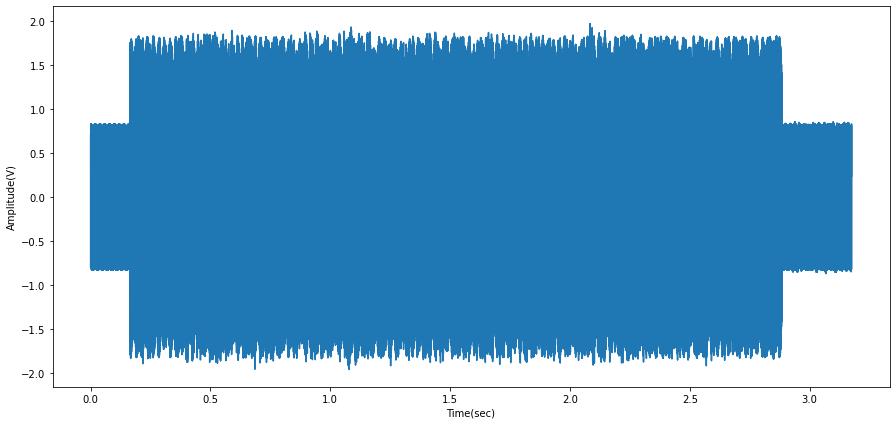

In [4]:
fig= plt.figure(figsize=(15,7))#size adjustment
plt.plot(np.linspace(0,L/Fs,L),Signal) #plot, rescale x-axis to display time
plt.ylabel('Amplitude(V)') 
plt.xlabel('Time(sec)') 

Text(0.5, 0, 'Frequency(Hz)')

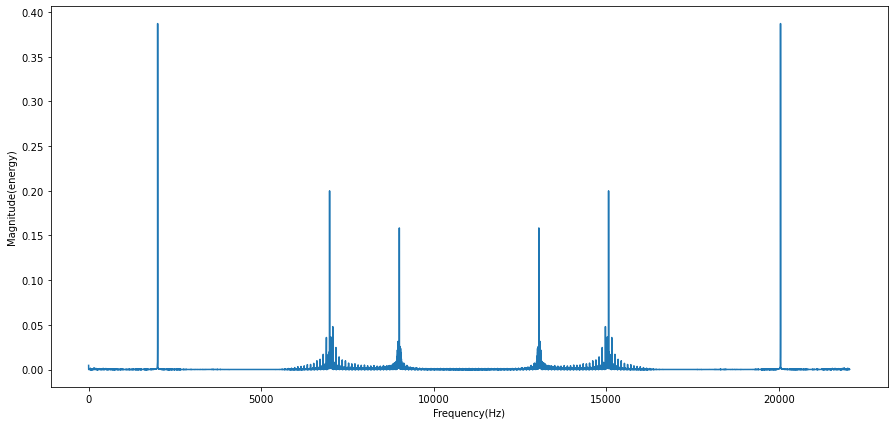

In [15]:
fig= plt.figure(figsize=(15,7))
magnitude = fft(Signal) #get fft of signal
freqs = np.linspace(0, Fs, L) #frequency vector
plt.plot(freqs, np.abs(magnitude)/L) 
plt.ylabel('Magnitude(energy)') 
plt.xlabel('Frequency(Hz)') 

In [292]:
signal1 = Signal.astype('float32') #convert to data type appropriate for .wav conversion
wavfile.write("signal.wav", Fs,signal1/max(signal1)) #save as .wav, normalize samples 

Text(0.5, 0, 'Frequency(Hz)')

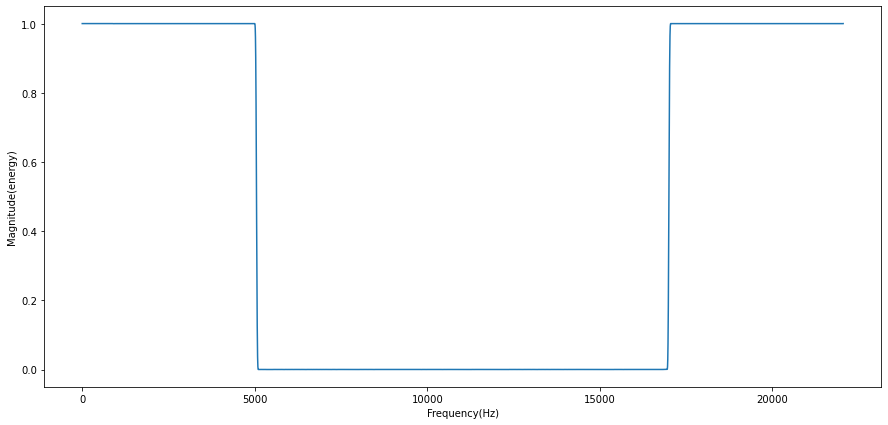

In [8]:
cutoff = 5000.0    # Desired cutoff frequency, Hz
trans_width = 100  # Width of transition from pass band to stop band, Hz
numtaps = 1001     # Size of the FIR filter.
taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*Fs], [1, 0], Hz=Fs) #returns filter coefficients
w, low_pass_filter = signal.freqz(taps, [1], worN=L,whole = True, fs=Fs) #uses coefficients to create the desired filter
fig= plt.figure(figsize=(15,7)) #plot filter's frequency response
plt.plot(w,np.abs(low_pass_filter))
plt.ylabel('Magnitude(energy)') 
plt.xlabel('Frequency(Hz)') 

Text(0.5, 0, 'Frequency(Hz)')

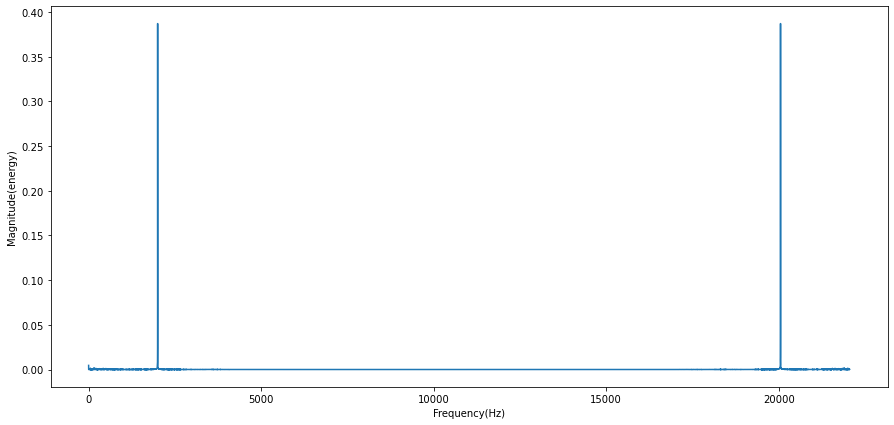

In [9]:
filtered_signal = magnitude*low_pass_filter #filter signal
fig= plt.figure(figsize=(15,7))
plt.plot(freqs,np.abs(filtered_signal)/L)
plt.ylabel('Magnitude(energy)') 
plt.xlabel('Frequency(Hz)') 

In [10]:
def iir_notch(z,r,w0): #z is the filter input, r filter parameter, w0 the frequency we want to remove
    return 0.5*(1+r**2)*(1-2*np.cos(w0)*z**(-1)+z**(-2))/(1-(1+r**2)*np.cos(w0)*z**(-1)+(r**2)*(z**(-2)))

Text(0.5, 0, 'Frequency(Hz)')

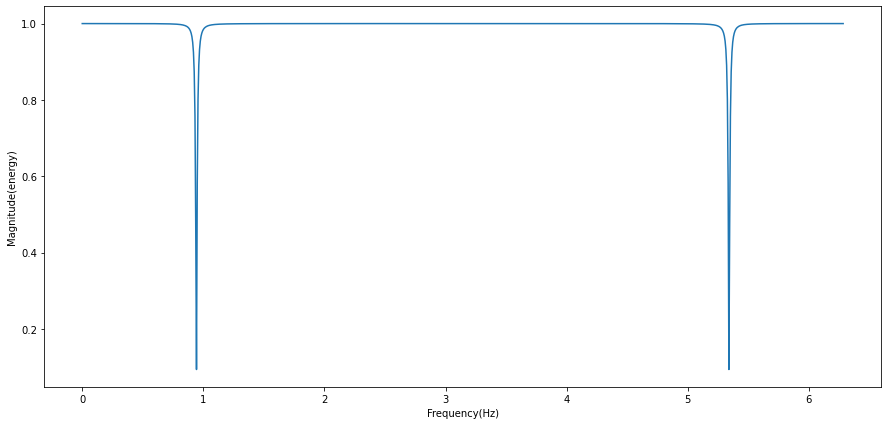

In [14]:
fig= plt.figure(figsize=(15,7))
freqs = np.linspace(0,2*np.pi,1000)
plt.plot(freqs,np.abs(iir_notch(np.exp(1j*freqs),0.99,0.3*np.pi))) #plot fequency response
plt.ylabel('Magnitude(energy)') 
plt.xlabel('Frequency(Hz)') 

Text(0.5, 0, 'Frequency(Hz)')

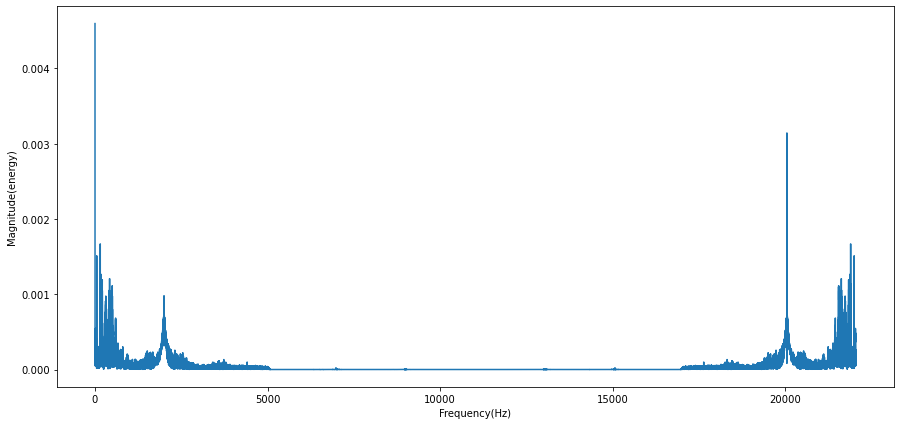

In [16]:
filtered_filtered_signal = iir_notch(np.exp(1j*np.linspace(0,2*np.pi,L)),0.99,w0)*filtered_signal #use notch filter to remove tone frequency
fig= plt.figure(figsize=(15,7))
plt.plot(freqs, np.abs(filtered_filtered_signal)/L) #plot the filtered frequency response
plt.ylabel('Magnitude(energy)') 
plt.xlabel('Frequency(Hz)') 

In [38]:
signal2 = ifft(filtered_filtered_signal).astype('float32') #get the IFFT of the filtered signal
wavfile.write("signal2.wav", Fs,signal2/max(signal2)) #normalize and save as .wav

<ipython-input-38-aa168d1e9259>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  signal2 = ifft(filtered_filtered_signal).astype('float32') #get the IFFT of the filtered signal


Text(0.5, 0, 'Samples')

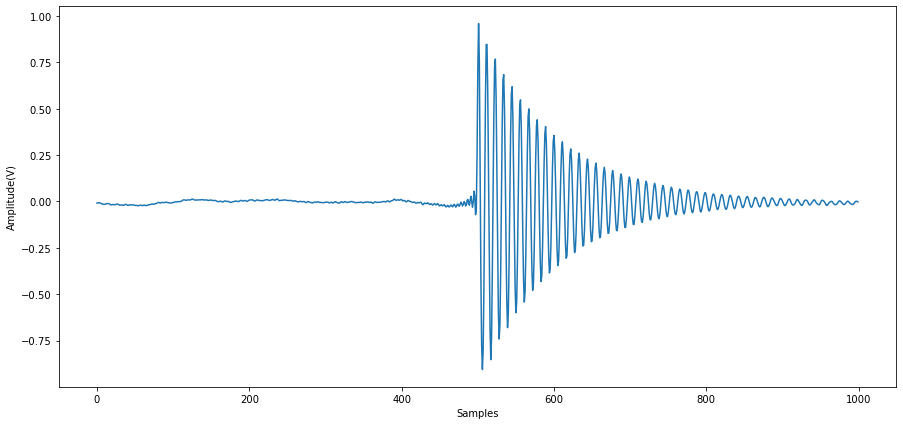

In [39]:
fig= plt.figure(figsize=(15,7))
plt.plot(signal2[:1000]) #plot, rescale x-axis to display time
plt.ylabel('Amplitude(V)') 
plt.xlabel('Samples') 

Text(0.5, 0, 'Frequency(Hz)')

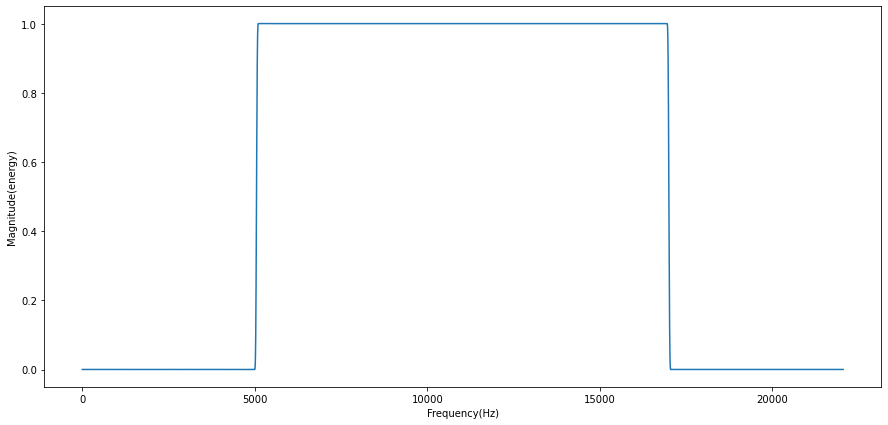

In [40]:
cutoff = 5000.0    # Desired cutoff frequency, Hz
trans_width = 100  # Width of transition from pass band to stop band, Hz
numtaps = 1001     # Size of the FIR filter.
taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*Fs], [0, 1], Hz=Fs)
w, high_pass_filter = signal.freqz(taps, [1], worN=L,whole = True, fs=Fs)
fig= plt.figure(figsize=(15,7))#προσαρμογή μεγέθους
plt.plot(w,np.abs(high_pass_filter))
plt.ylabel('Magnitude(energy)') 
plt.xlabel('Frequency(Hz)') 

Text(0.5, 0, 'Frequency(Hz)')

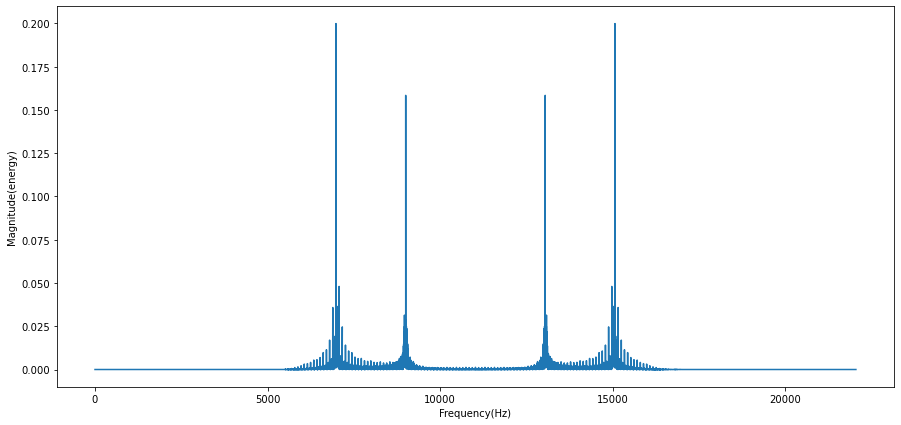

In [42]:
freqs = np.linspace(0, Fs, L) #frequency vector
filtered_data_spectrum = magnitude*high_pass_filter #apply filter to signal

fig= plt.figure(figsize=(15,7))
plt.plot(freqs,np.abs(filtered_data_spectrum)/L) #plot filtered signal magnitude
plt.ylabel('Magnitude(energy)') 
plt.xlabel('Frequency(Hz)') 

In [24]:
#define necessary filters
Lbit = 240 
λ0 = 7000/Fs
λ1 = 9000/Fs
n=np.linspace(0,239,240)
h1 = np.cos(2*np.pi*λ0*n)
h2 = np.sin(2*np.pi*λ0*n)
h3 = np.cos(2*np.pi*λ1*n)
h4 = np.sin(2*np.pi*λ1*n)

In [25]:
filtered_data_signal =ifft(filtered_data_spectrum) #get filtered signal in time domain

In [53]:
delay = (numtaps - 1)//2 #calculate FIR delay

In [68]:
currentIndex = delay #initialize index counter with FIR delay
code='' #stores the binary sequence
while True:
    try:
        data = filtered_data_signal[currentIndex:currentIndex+240] #store the 240 sample block
        if np.sqrt(np.convolve(h1,data)**2 + np.convolve(h2,data)**2)[240] > 50: #pass through first filter pair
            code+='0' #if its mid value is higher than threshold add 0 bit to code
        elif np.sqrt(np.convolve(h3,data)**2 + np.convolve(h4,data)**2)[240] > 50: #pass through second filter pair
            code+='1' #if its mid value is higher than threshold add 1 bit to code
        else: #else the block contains no data
            None
        currentIndex += 240 #increase index counter by 240
    except: #if out of samples bounds exit
        break

In [69]:
code

'1110010011111011110010101100101000001010111001001110100000011010001110101001000111000100000100110010100001001101001111000011010000110010001110110100111010010010101101000010010100110010010010100000100101010101000010010000010011100110010010101110001011'

In [70]:
alphabet = 'αβγδεζηθικλμνξοπρστυφχψω .'
dictionary = {i+1:alphabet[i] for i in range(len(alphabet))}

In [71]:
sentence = [dictionary[int(code[i:i+5][::-1],2)] for i in range(0,len(code),5)] #use dictionary to turn binary sequence to list
''.join(sentence) #list to string

In [72]:
''.join(sentence)

'η ψηφιακη επεξεργασια σηματων ειναι διασκεδαστικη.'